# Diabetes Prediction Challenge     ................................................................................................................................................
> # 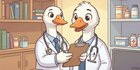  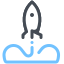 Playground Series - Season 5, Episode 12
>  **Your Goal: Predict the probability that a patient will be diagnosed with diabetes.**                 
>## Author: RIDDY MAZUMDER 
>## 🔗 Connect with Me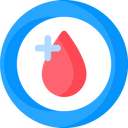
> [![Kaggle](https://img.shields.io/badge/Kaggle-20BEFF?style=for-the-badge&logo=kaggle&logoColor=white)](https://www.kaggle.com/riddymazumder)
> [![GitHub](https://img.shields.io/badge/GitHub-181717?style=for-the-badge&logo=github&logoColor=white)](https://github.com/RiddyMazumder)
> [![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/riddy-mazumder-7bab46338/)
> [![Gmail](https://img.shields.io/badge/Gmail-D14836?style=for-the-badge&logo=gmail&logoColor=white)](mailto:riddymazumder1971@gmail.com)

## Description 
**This notebook follows a complete end-to-end data science workflow, from loading data to model evaluation and final submission.**  
****Each section is clearly explained and well-structured for learning and presentation.****
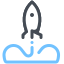
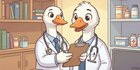
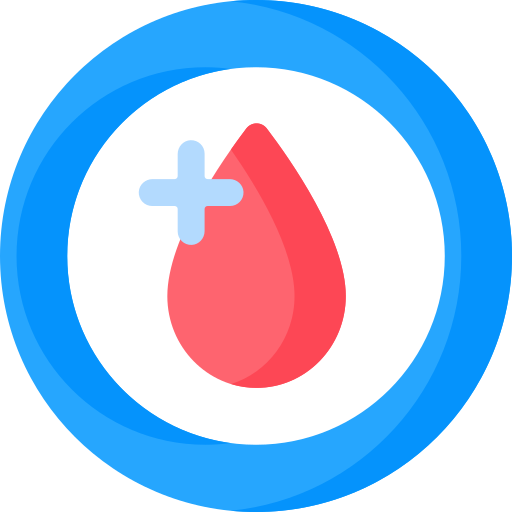
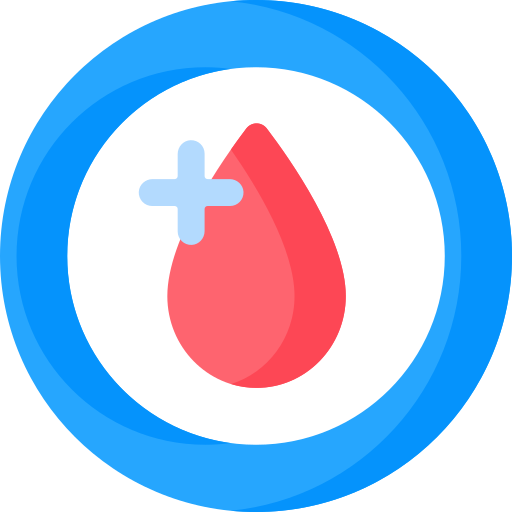
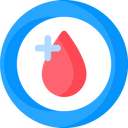
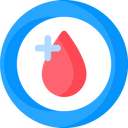
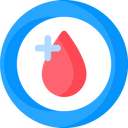
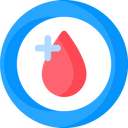
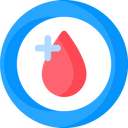
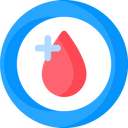
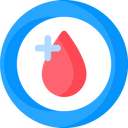

## 1. Libraries Required

****In this section, we import all the necessary Python libraries used throughout the project.****  
**These include libraries for**:
- **Data manipulation**  
- **Visualization**
- **Data Preprocessing**
- **Machine learning**

In [5]:
import os
import warnings
import numpy as np
import pandas as pd

In [6]:
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

In [8]:
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_selector
from sklearn.model_selection import StratifiedKFold

In [9]:
## Environment Setup

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = RuntimeWarning)
os.environ['LGBM_LOG_LEVEL'] = '-1'

/kaggle/input/playground-series-s5e12/sample_submission.csv
/kaggle/input/playground-series-s5e12/train.csv
/kaggle/input/playground-series-s5e12/test.csv


## 2. Load Dataset

In [10]:
## Data loading and initializing

train_path = "/kaggle/input/playground-series-s5e12/train.csv"
test_path = "/kaggle/input/playground-series-s5e12/test.csv"
df_train= pd.read_csv(train_path).drop("diagnosed_diabetes", axis = 1)
df_train_y = pd.read_csv(train_path)["diagnosed_diabetes"]
df_test = pd.read_csv(test_path)

## 3. Data Exploration & Cleaning

## 3.1 Overview

**Check shape, missing values, data types.**

In [24]:
df_train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,ldl_cholesterol,triglycerides,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,114,102,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,121,124,White,Highschool,Upper-Middle,Never,Employed,0,0,0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,114,108,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,85,123,White,Highschool,Lower-Middle,Current,Employed,0,1,0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,131,124,White,Highschool,Upper-Middle,Never,Retired,0,1,0


## 3.2 Visualization

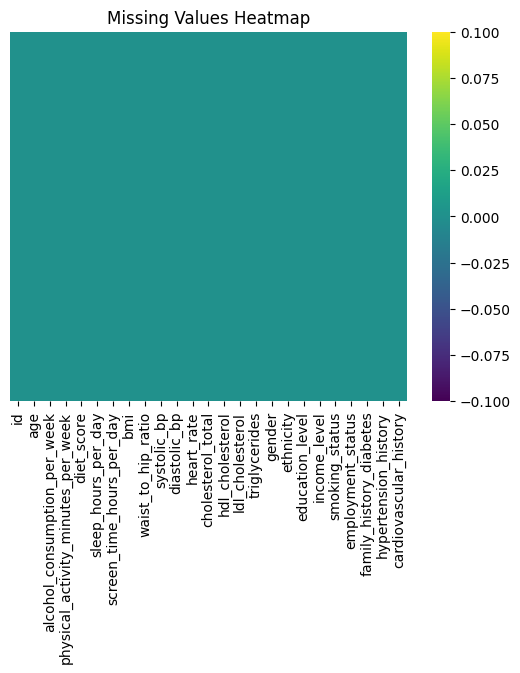

Missing Data Summary:



,Missing_Values,Percentage,Data_Type


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()
missing_data = pd.DataFrame({
    'Missing_Values': df_train.isnull().sum(),
    'Percentage': (df_train.isnull().sum() / len(df_train)) * 100,
    'Data_Type': df_train.dtypes
})
missing_data = missing_data[missing_data['Missing_Values'] > 0]
missing_data = missing_data.sort_values(by='Missing_Values', ascending=False)
print("Missing Data Summary:\n")
display(missing_data)

# 3.3 Remove irrelevant columns

In [11]:
df_train.drop("gender", axis = 1, inplace = True)
df_test.drop("gender", axis = 1, inplace = True)


# ========================================
# TOP FEATURE ENGINEERING FOR LOAN DEFAULT
# ========================================

In [12]:
## AGE & TRIGLYCERIDES
df_train["at_risk"] = df_train["triglycerides"] + df_train["triglycerides"] * df_train["age"] * 0.30
df_train["at_risk"] = df_train["at_risk"].astype(float)

df_test["at_risk"] = df_test["triglycerides"] + df_test["triglycerides"] * df_test["age"] * 0.30
df_test["at_risk"] = df_test["at_risk"].astype(float)

## AGE & FAMILY HISTORY INTERACTION
df_train["af_risk"] = df_train["family_history_diabetes"] + df_train["family_history_diabetes"] * df_train["age"] * 0.15
df_train["af_risk"] = df_train["af_risk"].astype(float)

df_test["af_risk"] = df_test["family_history_diabetes"] + df_test["family_history_diabetes"] * df_test["age"] * 0.15
df_test["af_risk"] = df_test["af_risk"].astype(float)

## CHOLESTEROL RATE
df_train["chol_rate"] = df_train["cholesterol_total"] / df_train["hdl_cholesterol"]
df_train["chol_rate"] = df_train["chol_rate"].astype(float)

df_test["chol_rate"] = df_test["cholesterol_total"] / df_test["hdl_cholesterol"]
df_test["chol_rate"] = df_test["chol_rate"].astype(float)


# 3.4 Encoding 

In [13]:
from sklearn.compose import make_column_selector

## Categorical Feature Handling to leverage LightGBM's native support
cat_feats = make_column_selector(dtype_include=object)(df_train)

df_train[cat_feats] = df_train[cat_feats].astype("category")
df_test[cat_feats] = df_test[cat_feats].astype("category")

## Optional: get indices of categorical features for LightGBM
# cat_features_indices = [df_train.columns.get_loc(col) for col in cat_feats]


In [14]:

print("Features ready:", df_train.shape)

Features ready: (700000, 27)


## 4. Model Building
**Libraries Required**
# 4.1 Separate processed train/test sets
# 4.2 Train Model,Evaluate Model

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier

MODEL_NAME = "Blend_CatBoost_LightGBM_GPU_10Fold"
seed = 42
n_splits = 5

# --------------------- Identify Categorical Features ---------------------
cat_features = df_train.select_dtypes(include=['category', 'object']).columns.tolist()
print(f"Categorical Features: {cat_features}")

# --------------------- Prepare Arrays ---------------------
oof_pred_lgb = np.zeros(len(df_train))
oof_pred_cat = np.zeros(len(df_train))
oof_target = df_train_y.values

kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# --------------------- Cross-Validation ---------------------
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_train, df_train_y)):
    print(f"\n=== Fold {fold+1}/{n_splits} ===")
    
    X_tr, X_val = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    y_tr, y_val = df_train_y.iloc[train_idx], df_train_y.iloc[valid_idx]
    
    # ----- LightGBM -----
    lgbm = LGBMClassifier(
        n_estimators=5000,
        learning_rate=0.02,
        max_depth=8,
        num_leaves=48,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=seed,
        n_jobs=-1,
        device='gpu',
        gpu_platform_id=0,
        gpu_device_id=0
    )
    lgbm.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)]
    )
    oof_pred_lgb[valid_idx] = lgbm.predict_proba(X_val)[:, 1]
    
    # ----- CatBoost -----
    cat = CatBoostClassifier(
        iterations=1500,
        learning_rate=0.03,
        depth=8,
        loss_function='Logloss',
        eval_metric='AUC',
        verbose=0,
        task_type='GPU',
        devices='0'
    )
    cat.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        early_stopping_rounds=50,
        verbose=0
    )
    oof_pred_cat[valid_idx] = cat.predict_proba(X_val)[:, 1]

# --------------------- Optimize Blend Weight and Threshold ---------------------
best_acc = 0
best_w = 0.6
best_thresh = 0.5

for w in np.arange(0.4, 0.7, 0.01):
    blended = w*oof_pred_cat + (1-w)*oof_pred_lgb
    for thresh in np.arange(0.3, 0.7, 0.001):
        acc = accuracy_score(oof_target, (blended > thresh).astype(int))
        if acc > best_acc:
            best_acc = acc
            best_w = w
            best_thresh = thresh

# Final blended predictions
oof_final = (best_w*oof_pred_cat + (1-best_w)*oof_pred_lgb > best_thresh).astype(int)

# --------------------- Metrics ---------------------
print(f"\nOptimized Blend Weight (CatBoost): {best_w:.2f}")
print(f"Optimized Threshold: {best_thresh:.3f}")
print(f"Optimized Accuracy: {best_acc:.5f}")
print(f"Overall AUC: {roc_auc_score(oof_target, best_w*oof_pred_cat + (1-best_w)*oof_pred_lgb):.5f}")


Categorical Features: ['ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']

=== Fold 1/5 ===
[LightGBM] [Info] Number of positive: 348936, number of negative: 211064
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2482
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 27
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (12.82 MB) transferred to GPU in 0.022198 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623100 -> initscore=0.502727
[LightGBM] [Info] Start training from score 0.502727
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further

Default metric period is 5 because AUC is/are not implemented for GPU



=== Fold 2/5 ===
[LightGBM] [Info] Number of positive: 348863, number of negative: 211137
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 27
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (12.82 MB) transferred to GPU in 0.020008 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622970 -> initscore=0.502172
[LightGBM] [Info] Start training from score 0.502172
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Default metric period is 5 because AUC is/are not implemented for GPU



=== Fold 3/5 ===
[LightGBM] [Info] Number of positive: 349096, number of negative: 210904
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 27
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (12.82 MB) transferred to GPU in 0.022443 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623386 -> initscore=0.503944
[LightGBM] [Info] Start training from score 0.503944
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Default metric period is 5 because AUC is/are not implemented for GPU



=== Fold 4/5 ===
[LightGBM] [Info] Number of positive: 349241, number of negative: 210759
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2479
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 27
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (12.82 MB) transferred to GPU in 0.020337 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623645 -> initscore=0.505047
[LightGBM] [Info] Start training from score 0.505047
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Default metric period is 5 because AUC is/are not implemented for GPU



=== Fold 5/5 ===
[LightGBM] [Info] Number of positive: 349092, number of negative: 210908
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2491
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 27
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (12.82 MB) transferred to GPU in 0.021430 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623379 -> initscore=0.503913
[LightGBM] [Info] Start training from score 0.503913
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Default metric period is 5 because AUC is/are not implemented for GPU



Optimized Blend Weight (CatBoost): 0.41
Optimized Threshold: 0.506
Optimized Accuracy: 0.68422
Overall AUC: 0.72638


# 5. Submission File

In [37]:
# Predict on test set
pred_lgb_test = lgbm.predict_proba(df_test)[:, 1]
pred_cat_test = cat.predict_proba(df_test)[:, 1]

# Blend predictions
pred_blend_test = best_w * pred_cat_test + (1 - best_w) * pred_lgb_test

# Create submission
submission = pd.DataFrame({
    'id': df_test['id'],
    'diagnosed_diabetes': pred_blend_test
})

# Save to CSV
submission.to_csv('submission.csv', index=False)


# Delete Submission File(If anything go wrong)

In [32]:
import os

file_path = "/kaggle/working/Blend_CatBoost_LightGBM_GPU_98_full_predictions.csv"

# Check if the file exists before deleting
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File deleted: {file_path}")
else:
    print("File not found, nothing to delete.")


File not found, nothing to delete.
